In [1]:
import torch
import torch.nn as nn
import numpy as np

import torchvision
import pathlib

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


# Loading Dataset (MNIST)

Batch size for training dataset: 1024
Batch size for test dataset: 10


In [2]:
batch_size_train = 1024
batch_size_test = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download = True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size= batch_size_test, shuffle=False
)


100%|██████████| 9912422/9912422 [00:00<00:00, 114397182.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41090805.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30937356.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22438785.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction (EBLO)

$\log p(x) \geq \log p(x|z) - KL[q(z|x)||p(x)]$

And we want minimal loss (convert $+ \rightarrow -$)


$L = -\log p(x) = \log p(x|c,z) + KL[q(z|x)||p(x)]$

$-\log p(x|c,z)$ : MSE is built in Pytorch

$\text{KL}[q(z|x)||p(x)]$ (Regularizer) : $q(z|x)$ doesn't rely on c value and p(x) also not since $p(x) = N(0,I)$.

$
\text{KL}[q(z|x)||p(x)] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$

In [3]:
def KL_div_N01(z_mu, z_log_sigma_sq):
  term_1 = z_log_sigma_sq.sum(axis=1) # trace log Sigma q
  term_2 = z_log_sigma_sq.exp().sum(axis=1) # trace Sigma q
  term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
  return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

# Build VAE(Without using c-label values): Using class material

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 2 neurons -> 512 neurons -> 784 neurons

In [ ]:

# ##
# ## fully connected
# ##
# class VAE( nn.Module ):
#     def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
#         super(VAE, self).__init__()

#         self.enc = nn.ModuleList()
#         self.dec = nn.ModuleList()
#         self.n_z = n_z

#         for i in range(n_layers+1):
#             if i == 0: #first layers
#                 self.enc.append(nn.Linear(n_input, layer_size))
#                 self.dec.append(nn.Linear(n_z, layer_size))
#                 self.enc.append(nn.ReLU())
#                 self.dec.append(nn.ReLU())
#             elif i == n_layers: #last layers
#                 self.enc.append(nn.Linear(layer_size, 2*n_z)) # we need this for enc's mu and sigma
#                 self.dec.append(nn.Linear(layer_size, n_output))
#             else:
#                 self.enc.append(nn.Linear(layer_size, layer_size))
#                 self.dec.append(nn.Linear(layer_size, layer_size))
#                 self.enc.append(nn.ReLU())
#                 self.dec.append(nn.ReLU())

#         self.enc = nn.Sequential(*self.enc)
#         self.dec = nn.Sequential(*self.dec)


#     def enc_to_mean_lss(self,x):
#         enc_output = self.enc(x)
#         mean = enc_output[...,:self.n_z]
#         log_sigma_sq = enc_output[...,self.n_z:]
#         return mean, log_sigma_sq

#     def forward(self, x):
#         mean, log_sigma_sq = self.enc_to_mean_lss(x)

#         sigma = log_sigma_sq.exp().sqrt()
#         z = mean + torch.randn_like(mean)*sigma
#         output = self.dec(z)

#         return output


#     def forward_train_with_label(self, x, c):
#         mean, log_sigma_sq = self.enc_to_mean_lss(x)
#         z = c + mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
#         output = self.dec(z)

#         return output, mean, log_sigma_sq

#     def forward_train(self, x):

#         mean, log_sigma_sq = self.enc_to_mean_lss(x)
#         print(mean.shape)
#         z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
#         output = self.dec(z)

#         return output, mean, log_sigma_sq

#     def encode_mean(self,x):
#         mean, log_sigma_sq = self.enc_to_mean_lss(x)
#         return mean

#     def encode(self,x):
#         mean, log_sigma_sq = self.enc_to_mean_lss(x)
#         sigma = self.enc_log_sigma_sq.exp().sqrt()
#         return mean + torch.randn_like(mean)*sigma

#     def decode(self,z):
#         return self.dec(z)



# Build cVAE in Pytorch (VAE with c-label values)

$x^{(i)} \in \mathbb{R}^{784}$,
$z^{(i)} \in \mathbb{R}^{2}$,
$c^{(i)} \in \mathbb{R}$


And I will construct 3 layers for each encoder and decoder.

Encoder: 784 neurons -> 512 neurons -> 2 neurons

Decoder: 3 neurons ($P(x|c,z)$) -> 512 neurons -> 784 neurons



In [4]:
class cVAE(nn.Module):
  def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
    super(cVAE, self).__init__()

    self.enc = nn.ModuleList()
    self.dec = nn.ModuleList()
    self.n_z = n_z

    for i in range(n_layers+1):
      if i == 0: #first layer: we put first input (x) into hidden layer
        self.enc.append(nn.Linear(n_input, layer_size))
        self.dec.append(nn.Linear(n_z+1, layer_size))
        #self.dec.append(nn.Linear(n_z, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())
      elif i == n_layers:
        self.enc.append(nn.Linear(layer_size, 2*n_z)) # 2*n_z is because we need mu and sigma
        self.dec.append(nn.Linear(layer_size, n_output))
      else:
        self.enc.append(nn.Linear(layer_size, layer_size))
        self.dec.append(nn.Linear(layer_size, layer_size))
        self.enc.append(nn.ReLU())
        self.dec.append(nn.ReLU())

    self.enc = nn.Sequential(*self.enc)
    self.dec = nn.Sequential(*self.dec)


  # can you explain this part? can you visualize what z looks like since we 2*n_z for enc
  def enc_to_mean_lss(self,x):
    enc_output = self.enc(x)
    #print("shape of enc_output is")
    #print(enc_output.shape)
    mean = enc_output[...,:self.n_z]
    log_sigma_sq = enc_output[...,self.n_z:]
    return mean, log_sigma_sq

  # What does it do?
  def forward(self, x):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    sigma = log_sigma_sq.exp().sqrt()
    z = mean + torch.randn_like(mean)*sigma
    #c = c.view(c.shape[0],1)
    #c_z = torch.concat((z,c), -1)

    output = self.dec(z)

    return output

  def forward_train(self, x, c):
    m, log_sigma_sq = self.enc_to_mean_lss(x)
    z = m + torch.randn_like(m) * (log_sigma_sq.exp().sqrt())
    c = c.view(c.shape[0],1)
    c_z = torch.concat((z,c), -1)
    #print("mean shape")
    #print(m.shape)
    #print("z shape ")
    #print(z.shape)
    output = self.dec(c_z)
    #print("output shape")
    #print(output.shape)
    return output, m, log_sigma_sq

  def encode_mean(self,x):
    m, s = self.enc_to_mean_lss(x)
    return m

  def encode(self,x):
    mean, log_sigma_sq = self.enc_to_mean_lss(x)
    sigma = self.enc_log_sigma_sq.exp().sqrt()
    return mean + torch.randn_like(mean)*sigma

  def decode(self,z):
    #c = c.view(c.shape[0],1)
    #c_z = torch.concat((z,c), -1)
    return self.dec(z)



# Training cVAE

In [5]:
input_size = 28**2
n_z = 2 # z
n_layers = 3
layer_size = 512

saved_params_path = "saved_params_cvae"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# want 100 epochs
n_epochs = 100

cvae_instance = cVAE(n_input = input_size, n_output= input_size, n_z = n_z, n_layers= n_layers, layer_size = layer_size)

mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01
optimizer = torch.optim.Adam(cvae_instance.parameters())

for epoch in range(n_epochs):
  running_loss = 0.0
  running_kl_loss = 0.0
  running_mse_loss = 0.0
  running_n = 0

  for i, data in enumerate(train_loader, 0):
    # input : image
    # label : label to image
    inputs, labels = data
    #print("Shape of input is ")
    #print(inputs.shape)
    #print("Shape of label is ")
    #print(labels.shape)

    images_in = inputs.view(inputs.shape[0], -1).clone().detach()

    optimizer.zero_grad()
    x_hat, mean, log_sigma_sq = cvae_instance.forward_train(images_in, labels)
    #x_hat, mean, log_sigma_sq = cvae_instance.forward_train(images_in)

    mse_loss = mse_loss_func(x_hat, images_in)
    kl_div_loss = kl_loss_func(mean, log_sigma_sq)
    loss = mse_loss + kl_div_loss
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_kl_loss += kl_div_loss.item()
    running_mse_loss += mse_loss.item()
    running_n += inputs.shape[0]

    print(
        f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
        f'KL loss: {running_kl_loss / running_n:.6f}',
        f'MSE loss: {running_mse_loss / running_n:.6f}')
    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0

    torch.save(cvae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

  torch.save(cvae_instance.state_dict(), 'final_model.pth')
  torch.save(optimizer.state_dict(), 'optimizer.pth')

  print('Finished Training')







Streaming output truncated to the last 5000 lines.
[17,    41] loss: 2.522505 KL loss: 0.020742 MSE loss: 2.501762
[17,    42] loss: 2.431238 KL loss: 0.019676 MSE loss: 2.411562
[17,    43] loss: 2.426047 KL loss: 0.018559 MSE loss: 2.407488
[17,    44] loss: 2.521586 KL loss: 0.020090 MSE loss: 2.501497
[17,    45] loss: 2.455347 KL loss: 0.018969 MSE loss: 2.436378
[17,    46] loss: 2.465991 KL loss: 0.018067 MSE loss: 2.447925
[17,    47] loss: 2.537411 KL loss: 0.018999 MSE loss: 2.518412
[17,    48] loss: 2.491666 KL loss: 0.019675 MSE loss: 2.471991
[17,    49] loss: 2.476153 KL loss: 0.019791 MSE loss: 2.456362
[17,    50] loss: 2.456426 KL loss: 0.018744 MSE loss: 2.437681
[17,    51] loss: 2.544966 KL loss: 0.019603 MSE loss: 2.525362
[17,    52] loss: 2.454048 KL loss: 0.019365 MSE loss: 2.434683
[17,    53] loss: 2.462343 KL loss: 0.018955 MSE loss: 2.443388
[17,    54] loss: 2.504277 KL loss: 0.019569 MSE loss: 2.484708
[17,    55] loss: 2.554038 KL loss: 0.019567 MSE loss

# Training VAE

In [ ]:
# ## network params
# input_size = 28**2
# n_z = 2
# n_layers = 3
# layer_size = 512

# saved_params_path="saved_params_vae"
# pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# ## training params
# n_epochs = 100

# vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)

# # Define the loss function.
# mse_loss_func = torch.nn.MSELoss()
# kl_loss_func = KL_div_N01

# # Define the optimizer.
# optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)

# print(vae_instance)
# for epoch in range(n_epochs):

#     running_loss = 0.0
#     running_kl_loss = 0.0
#     running_mse_loss = 0.0
#     running_n = 0

#     for i, data in enumerate(train_loader, 0):

#         inputs, labels = data
#         print(labels.shape)

#         images_in = inputs.view(inputs.shape[0], -1).clone().detach()

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         x_hat, mean, log_sigma_sq  = vae_instance.forward_train(images_in)

#         mse_loss = mse_loss_func(x_hat, images_in)
#         kl_div_loss = kl_loss_func(mean, log_sigma_sq)
#         loss = mse_loss + kl_div_loss
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         running_kl_loss += kl_div_loss.item()
#         running_mse_loss += mse_loss.item()
#         running_n += inputs.shape[0]

#     print(
#         f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
#         f'KL loss: {running_kl_loss / running_n:.6f}',
#         f'MSE loss: {running_mse_loss / running_n:.6f}')
#     running_loss = 0.0
#     running_kl_loss = 0.0
#     running_mse_loss = 0.0
#     running_n = 0

#     torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# # Save the trained model
# torch.save(vae_instance.state_dict(), 'final_model.pth')
# # Save the optimization states. This is helpful for continual training.
# torch.save(optimizer.state_dict(), 'optimizer.pth')

# print('Finished Training')

# Evaluation and Plotting

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(decode_function, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):

    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))

    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])

            x_hat = decode_function(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def imshow(img):
    npimg = img.numpy()
    npimg = np.clip(npimg/255.,0,1) #we need to clip here to avoid bad image values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Test Data for VAE

9
torch.Size([10, 1, 28, 28])


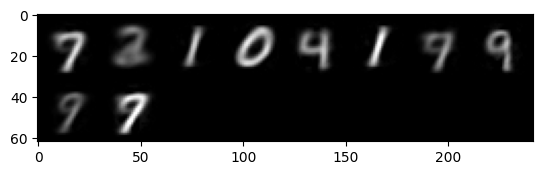

19
torch.Size([10, 1, 28, 28])


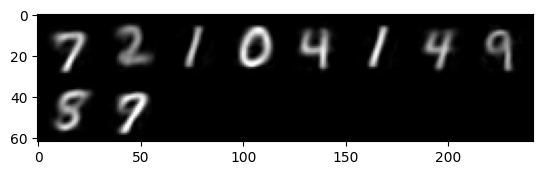

29
torch.Size([10, 1, 28, 28])


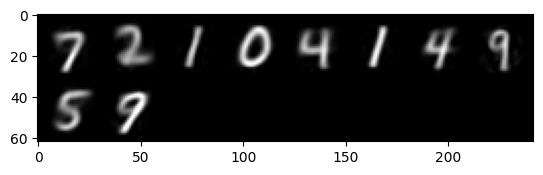

39
torch.Size([10, 1, 28, 28])


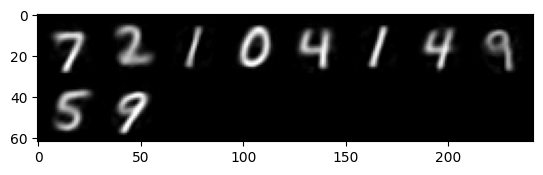

49
torch.Size([10, 1, 28, 28])


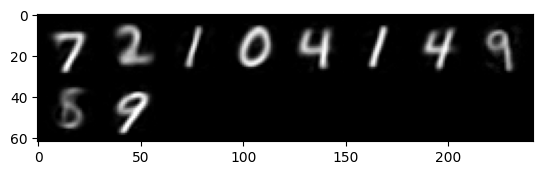

59
torch.Size([10, 1, 28, 28])


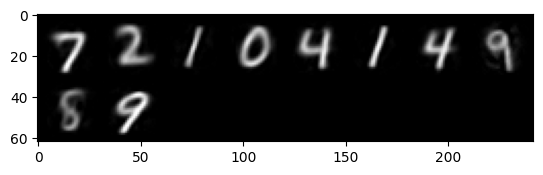

69
torch.Size([10, 1, 28, 28])


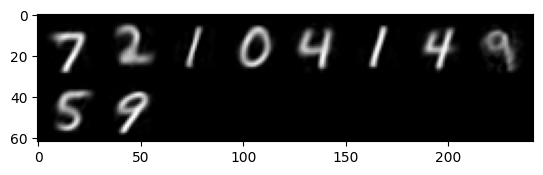

79
torch.Size([10, 1, 28, 28])


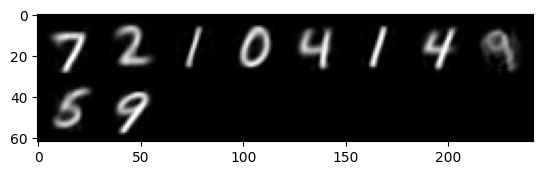

89
torch.Size([10, 1, 28, 28])


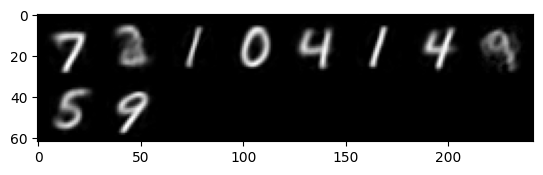

99
torch.Size([10, 1, 28, 28])


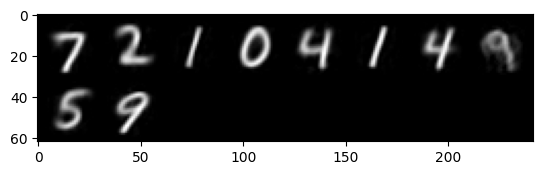

In [9]:

cvae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch
#labels = torch.Tensor([9, 3, 7, 8, 7, 1, 7, 6, 4, 8])
for epoch in range(9,100,10):
    print(epoch)
    cvae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = cvae_instance.forward_train(images_in, labels)

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)

    imshow(image_outputs)

# Test Data for cVAE

In [ ]:
labels = torch.Tensor([9, 3, 7, 8, 7, 1, 7, 6, 4, 8])


In [ ]:
labels

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])